<a href="https://colab.research.google.com/github/box-lin/csml/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'craigslist-carstrucks-data' dataset.
Path to dataset files: /kaggle/input/craigslist-carstrucks-data


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing  import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor


from sklearn.metrics import r2_score
import joblib

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(f"{path}/vehicles.csv", low_memory=False)
df1 = df.copy()
print(df1.shape)
print(df1.columns)


(426880, 26)
Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')


In [6]:
df1.drop(columns = ['id','url','region_url','VIN','image_url','description','state', 'lat', 'long','posting_date'],axis = 1,inplace =True)

In [7]:
df1.isnull().sum()


,0
region,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
cylinders,177678
fuel,3013
odometer,4400
title_status,8242


In [8]:
df1.isna().mean()


,0
region,0.000000
price,0.000000
year,0.002823
manufacturer,0.041337
model,0.012362
condition,0.407852
cylinders,0.416225
fuel,0.007058
odometer,0.010307
title_status,0.019308


In [9]:
null_columns = df1.columns[df1.isnull().mean()>0.25]
df1.drop(columns = null_columns,axis =1,inplace=True)

In [10]:
cat_cols = df1.columns[df1.dtypes == 'object']
num_cols = df1.columns[df1.dtypes != 'object']
print(f'The categorical columns are {cat_cols}.\n\n')
print(f'The numerical columns are {num_cols}.\n\n')

The categorical columns are Index(['region', 'manufacturer', 'model', 'fuel', 'title_status',
       'transmission', 'type'],
      dtype='object').


The numerical columns are Index(['price', 'year', 'odometer'], dtype='object').




In [11]:
df1[cat_cols].isna().sum()


,0
region,0
manufacturer,17646
model,5277
fuel,3013
title_status,8242
transmission,2556
type,92858


In [12]:
df1[cat_cols].columns[df1[cat_cols].isna().sum().sort_values(ascending=False)>10000]


Index(['region', 'manufacturer'], dtype='object')

In [13]:
df1.drop(columns = ['region', 'manufacturer', 'model', 'fuel'],axis =1, inplace=True)


In [14]:
df1.drop(df1[df1['odometer'].isnull()].index,axis = 0,inplace =True)
df1.drop(df1[df1['type'].isnull()].index,axis = 0,inplace =True)
df1.drop(df1[df1['title_status'].isnull()].index,axis = 0,inplace =True)
df1.drop(df1[df1['year'].isnull()].index,axis = 0,inplace =True)
df1.drop(df1[df1['transmission'].isnull()].index,axis = 0,inplace =True)

In [15]:
df1.isnull().sum()


,0
price,0
year,0
odometer,0
title_status,0
transmission,0
type,0


In [16]:
df1['year'] = df1['year'].astype(int)


In [17]:
df1.drop(df1[(df1['price']>=0)&(df1['price']<=100)].index,axis =0,inplace=True)


In [18]:
round(df1.describe())


,price,year,odometer
count,2.951620e+05,295162.0,295162.0
mean,4.367600e+04,2012.0,91512.0
std,7.648675e+06,9.0,158929.0
min,1.010000e+02,1900.0,0.0
25%,8.250000e+03,2009.0,34413.0
50%,1.699000e+04,2014.0,80465.0
75%,2.890000e+04,2017.0,129659.0
max,3.736929e+09,2022.0,10000000.0


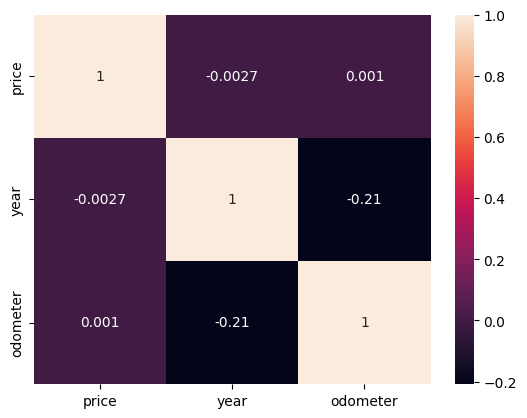

In [19]:
sns.heatmap(df1[['price','year','odometer']].corr(),annot =True)
plt.show()

In [20]:
df1[df1['price'] >= 249999].sort_values(by='price',ascending=False)


,price,year,odometer,title_status,transmission,type
318592,3736928711,2007,164000.0,clean,automatic,pickup
184704,1410065407,1989,103000.0,clean,manual,SUV
29386,1111111111,1999,149000.0,clean,automatic,pickup
230753,135008900,2008,110500.0,clean,automatic,truck
193736,123456789,2015,64181.0,clean,automatic,sedan
137807,123456789,1999,96000.0,clean,automatic,sedan
307488,123456789,1996,320000.0,clean,automatic,pickup
207080,123456789,2003,1234567.0,clean,automatic,pickup
136516,17000000,2007,170000.0,rebuilt,automatic,pickup
303644,12345678,2019,100000.0,clean,automatic,truck


In [21]:
df1.drop(df1[df1['price'] >= 249999].index,axis =0,inplace =True)


In [22]:
def year_categ(number):

    if number <= 1945:
        return 'ancient'
    elif number >1945 and number <= 1980:
        return 'old'
    elif number >1980 and number <= 2015:
        return 'middle'
    else:
        return 'new'

In [23]:
df1['year'] = df1['year'].apply(year_categ)


In [24]:
df1 = pd.get_dummies(data=df1,columns=[ 'year','title_status', 'transmission','type'],dtype=int)


In [25]:
y = df1['price']
X = df1.drop(columns = ['price'],axis =1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=345)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(236093, 27) (59024, 27) (236093, 1) (59024, 1)


In [26]:
scaler1 = MinMaxScaler()

X_train_sc = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc,columns=X_train.columns)

X_test_sc = scaler1.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc,columns=X_test.columns)

y_train_sc = scaler1.fit_transform(y_train)
y_train = pd.DataFrame(y_train_sc,columns=y_train.columns)

y_test_sc = scaler1.fit_transform(y_test)
y_test = pd.DataFrame(y_test_sc,columns=y_test.columns)

In [27]:
def evaluate_regressors(X_train,X_test,y_train,y_test):

    models = {'lr':LinearRegression()
            ,'DecisionTreeRegressor':DecisionTreeRegressor()
            ,'RandomForestRegressor':RandomForestRegressor()
            ,'ExtraTreesRegressor':ExtraTreesRegressor()
            }

    results=[]
    for name,model in models.items():

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test,y_pred)
        results.append({"name":name,"Model":model,"r2":r2})

    df_results = pd.DataFrame(results).sort_values(by=['r2'],ascending=False, ignore_index= True)
    return df_results

df_scores = evaluate_regressors(X_train,X_test,y_train,y_test)
print(df_scores)

                    name                                              Model  \
0  RandomForestRegressor  (DecisionTreeRegressor(max_features=1.0, rando...   
1    ExtraTreesRegressor  (ExtraTreeRegressor(random_state=1545449172), ...   
2  DecisionTreeRegressor                            DecisionTreeRegressor()   
3                     lr                                 LinearRegression()   

         r2  
0  0.728082  
1  0.717604  
2  0.670027  
3  0.424740  


In [28]:
print(f"The best model is {df_scores.iloc[0,0]} with the r2 score of {df_scores.iloc[0,2]}.")


The best model is RandomForestRegressor with the r2 score of 0.7280820925831284.
